# Bayesian inference: MCMC hands-on

## VI. Implementing your own MCMC

As we have seen, the standard Bayesian approach to model fitting involves sampling the posterior, usually via a variant of Markov Chain Monte Carlo (MCMC). Though there are many very sophisticated MCMC samplers out there, the most simple algorithm (Metropolis-Hastings) is rather straightforward to code.

Here we'll walk through creating our own Metropolis-Hastings sampler from scratch, in order to better understand exactly what is going on under the hood.

In [1]:
# As usual, we start with some imports
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats

### VI.1 Metropolis-Hastings Procedure

Recall the Metropolis-Hastings procedure:

1. Define a posterior $p(\theta~|~D, I)$
2. Define a *proposal density* $p(\theta_{i + 1}~|~\theta_i)$, which must be a symmetric function, but otherwise is unconstrained (a Gaussian is the usual choice).
3. Choose a starting point $\theta_0$
4. Repeat the following:

   1. Given $\theta_i$, draw a new $\theta_{i + 1}$ from the proposal distribution
   
   2. Compute the *acceptance ratio*
      $$
      a = \frac{p(\theta_{i + 1}~|~D,I)}{p(\theta_i~|~D,I)}
      $$
   
   3. If $a \ge 1$, the proposal is more likely: accept the draw and add $\theta_{i + 1}$ to the chain.
   
   4. If $a < 1$, then accept the point with probability $a$: this can be done by drawing a uniform random number $r$ and checking if $a < r$. If the point is accepted, add $\theta_{i + 1}$ to the chain. If not, then add $\theta_i$ to the chain *again*.
   
The goal is to produce a "chain", i.e. a list of $\theta$ values, where each $\theta$ is a vector of parameters for your model.
Here we'll write a simple Metropolis-Hastings sampler in Python.

Note that the ``np.random.randn()`` function will be useful: it returns a pseudorandom value drawn from a standard normal distribution (i.e. mean of zero and variance of 1).

### VI.2 Implementation

The cells below describe the various steps that you will implement by yourself

*Data:* We'll use data drawn from a straight line model

In [2]:
def make_data(intercept, slope, N=20, dy=2, rseed=42):
    rand = np.random.RandomState(rseed)
    x = 100 * rand.rand(20)
    y = intercept + slope * x
    y += dy * rand.randn(20)
    return x, y, dy * np.ones_like(x)

theta_true = (2, 0.5)
x, y, dy = make_data(*theta_true)

First plot the data to see what we're looking at (Use a ``plt.errorbar()`` plot with the provided data)

<ErrorbarContainer object of 3 artists>

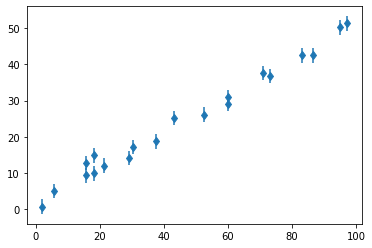

In [3]:
plt.errorbar(x, y, yerr=dy, marker='d', ls='')

Our model will also be a line, as we have done in the previous lecture. 

In [4]:
def model(theta, x):
    '''
    Straight line model 
    
    Parameters: 
    theta = np.array(2,) with  theta[0] = Slope ; theta[1] = Intercept
    x = np.array(n) = data points over which the model is evaluated 
    '''
    # the `theta` argument is a list of parameter values, e.g., theta = [slope, intercept] for a line
    return theta[0] * x + theta[1]

We'll start with the assumption that the data are independent and identically distributed so that the likelihood is simply a product of Gaussians (one big Gaussian). We'll also assume that the uncertainties reported are correct, and that there are no uncertainties on the `x` data. We need to define a function that will evaluate the (ln)likelihood of the data, given a particular choice of your model parameters. A good way to structure this function is as follows:

In [5]:
def ln_likelihood(theta, x, y, dy):
    '''
    Log likelihood for model defined in the function model() 
    Parameters: 
    theta = np.array(2,) = parameters of the model ([slope, intercept])
    x, y, dy  = np.array(n) = x, y, dy of the data
    '''
    # we will pass the parameters (theta) to the model function
    # the other arguments are the data
    y_model = model(theta, x)
    return -0.5 * np.sum( np.log(2 * np.pi * dy ** 2) + (y - y_model) ** 2 / dy ** 2 )


What about priors? Remember your prior only depends on the model parameters, but be careful about what kind of prior you are specifying for each parameter. Do we need to properly normalize the probabilities?

In [6]:
def ln_prior(theta):
    if (np.abs(theta[0]) < 1000):
        return 0 # log(1)
    else:
        return -np.inf  # log(0)
    return

Now we can define a function that evaluates the (ln)posterior probability, which is just the sum of the ln prior and ln likelihood:

In [7]:
def ln_posterior(theta, x, y, dy):
    return ln_prior(theta) + ln_likelihood(theta, x, y, dy)

Now write a function to actually run a Metropolis-Hastings MCMC sampler. Ford (2005) includes a great step-by-step walkthrough of the Metropolis-Hastings algorithm, and we'll base our code on that. Fill-in the steps mentioned in the comments below:

In [22]:
def run_mcmc(ln_posterior, nsteps, theta0, stepsize, args=()):
    """
    Run a Markov Chain Monte Carlo
    
    Parameters
    ----------
    ln_posterior: callable
        our function to compute the posterior
    nsteps: int
        the number of steps in the chain
    theta0: list
        the starting guess for parameters theta
    stepsize: float
        a parameter controlling the size of the random step
        e.g. it could be the width of the Gaussian distribution
    args: tuple 
        additional arguments (data) passed to ln_posterior
    """
    x, y, dy = args
    # Create the array of size (nsteps, ndims) to hold the chain; ndims is the number of params
    ndims = len(theta0)  
    chain = np.zeros(shape=(nsteps, ndims))
    # Initialize the first row of this with theta0
    chain[0,:] = theta0
    # Create the array of size nsteps to hold the ln-posterior for each point
    post = np.zeros(nsteps)   # <- 
    # Initialize the first entry of this with the ln-posterior at theta0
    post[0] = ln_posterior(theta0, x, y, dy)  #  <- 
    p_accept_arr =  np.zeros(nsteps)  # Array to save the acceptance ratios 
    # Loop for nsteps
    for i in range(1, nsteps):
        # Randomly draw a new theta from the proposal distribution.
        # for example, you can do a normally-distributed step by utilizing
        # the scipy.random.normal() function
        theta_new = chain[i-1, :] + scipy.stats.norm.rvs(0, stepsize, ndims)
        
        # Calculate the probability for the new state
        lnpnew = ln_posterior(theta_new, x, y, dy)
        
        # Compare it to the probability of the old state
        # Using the acceptance probability function
        # (remember that you've computed the log probability, not the probability!)
        p_accept = np.exp(lnpnew) / np.exp(post[i-1])
        # Alternative: lnp_accept = lnpnew - post[i-1]
        
        # Chose a random number r between 0 and 1 to compare with p_accept
        r = np.random.rand()
        
        # If p_accept>1 or p_accept>r, accept the step
        if  (p_accept > 1) or (p_accept> r):
            # Save the position to the i^th row of the chain
            chain[i, :] = theta_new
            # Save the probability to the i^th entry of the array
            post[i] = lnpnew
            p_accept_arr[i] = p_accept
        # Else, do not accept the step
        else:
            post[i] = post[i-1]
            # Set the position and probability are equal to the previous values
            chain[i,:] = chain[i-1,:]
        
    # Return the chain and probabilities
    
    return chain, post, p_accept_arr

Now run the MCMC code on the data provided.

In [23]:
t0 = [0, -10]
nsteps, stepsize=30000, 0.14   # Beware of the step size !! 
# If you change the step size, you'll see that the chain may remain
# stuck locally ; or not be able to end up close to the max posterior
# If too small step, you stay close to your starting values 
chain_ini, posterior, p_accept = run_mcmc(ln_posterior, 
                                          nsteps, 
                                          theta0=t0, 
                                          stepsize=stepsize, 
                                          args=(x,y,dy))

/Users/dsluse/miniconda3/envs/intel-python3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars
/Users/dsluse/miniconda3/envs/intel-python3/lib/python3.7/site-packages/ipykernel_launcher.py:43: RuntimeWarning: divide by zero encountered in double_scalars


Plot the position of the walker as a function of step number for each of the parameters. Are the chains converged? 

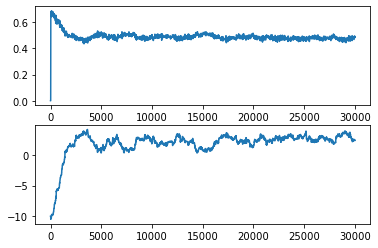

In [24]:
f, ax = plt.subplots(nrows=2)
for i in range(2):
    ax[i].plot(chain_ini[:,i])

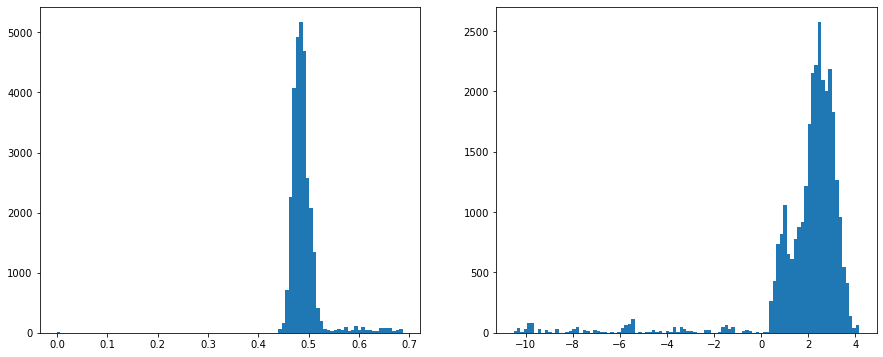

In [25]:
# Plotting the histogram for each parameters
f, ax = plt.subplots(ncols=2, figsize=(15,6))
for i in range(2):
    ax[i].hist(chain_ini[:,i], bins=100)

We see a rather well defined Gaussians but also substantial counts far from the "gaussian". Those are samples from the burn-in that we should get rid of. Those samples are not statistically representative samples of the posterior. 

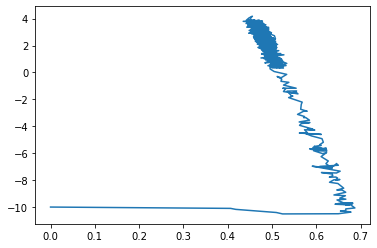

In [26]:
f, ax = plt.subplots(nrows=1)
ax.plot(chain_ini[:,0], chain_ini[:,1])

Make histograms of the samples for each parameter. Should you include all of the samples? 

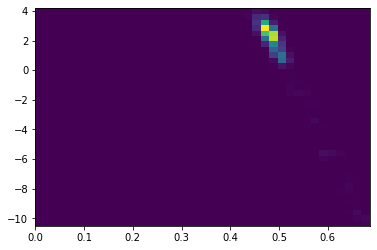

In [27]:
# To plot a 2D histogram, consider the use of plt.hist2d()  ; you can also use corner as last time
h2 = plt.hist2d(chain_ini[:,0], chain_ini[:,1], bins=40)

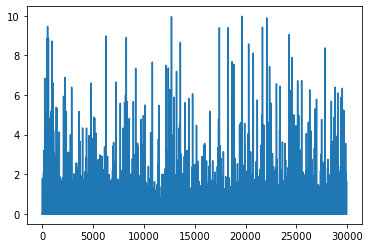

In [30]:
# we can also plot the acceptance rate 
plt.plot(p_accept[p_accept < 10])  # for visualisation, we get rid of the very large acceptance rate

In [31]:
# We can look at the acceptance rate of our chain
np.nanmean(p_accept[p_accept< 10]), np.nanmean(p_accept[10000:])
# A good acceptance rate should be of the order of 20-25% 

(0.09273331333553105, 0.1293117584613742)

In [32]:
# We can also Re-run the chain from the final position to have better behaved chains 
# This also gets rid of the burn-in 
new_stepsize=(0.04, 0.8)  # We use a different step size along p1 and p2 (slope and intercept)
#new_stepsize = 0.3
chain, posterior, p_accept2 = run_mcmc(ln_posterior, nsteps, theta0=chain_ini[-1,:], stepsize=new_stepsize, args=(x,y,dy))

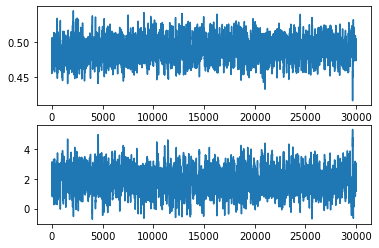

In [33]:
# We can simply visualise the chain for the different parameters 
f, ax = plt.subplots(nrows=2)
for i in range(2):
    ax[i].plot(chain[:,i])

In [34]:
np.nanmean(p_accept2[p_accept2< 10]), np.nanmean(p_accept2[10000:])

(0.2710303574239161, 0.45089581833810516)

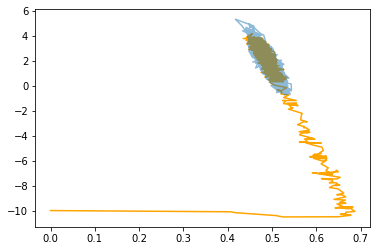

In [35]:
# We can compare the new chain with the previous one
f, ax = plt.subplots(nrows=1)
ax.plot(chain_ini[:,0], chain_ini[:,1], color='orange')
ax.plot(chain[:,0], chain[:,1], alpha=0.5)

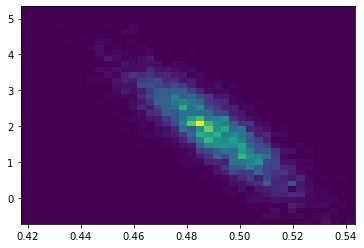

In [36]:
h2 = plt.hist2d(chain[:,0], chain[:,1], bins=40)

Report to us your constraints on the model parameters.   
This is the number for the abstract of the paper (or to report in the text of your thesis work) – the challenge is to figure out how to accurately summarize a multi-dimensional posterior (which is **the result** in Bayesianism) with a few numbers (which is what readers want to see as they skim the paper/thesis/report).

What numbers should you use?

In [37]:
theta_best = chain.mean(0)
theta_std = chain.std(0)

print('true intercept:%.1f'%theta_true[0] )
print('true slope:%.2f'%theta_true[1] )
print('intercept = %.2f +/- %.2f.'%(theta_best[1], theta_std[1]) )
print('slope = %.2f +/- %.2f'%(theta_best[0], theta_std[0]) )

true intercept:2.0
true slope:0.50
intercept = 1.89 +/- 0.85.
slope = 0.49 +/- 0.02


Note that the std of the posterior is effectively the standard error on the parameter. You can instead use percentiles to build *credible intervals*. 

In [38]:
theta_percent = np.percentile(chain, [0.025,  0.975, 0.5], axis=0)
print('intercept: median=%.2f'%theta_percent[2, 0])
print(' CI (95pcts)= [%.3f, %.3f]'%(theta_percent[0, 0] ,theta_percent[1, 0] ))      
print('slope: median=%.2f'%theta_percent[2, 1])
print(' CI (95pcts)= [%.3f, %.3f]'%(theta_percent[0, 1] ,theta_percent[1, 1] ))      

intercept: median=0.45
 CI (95pcts)= [0.440, 0.454]
slope: median=-0.28
 CI (95pcts)= [-0.681, -0.083]


In [39]:
# Note that you can also calculate the covariance from your posterior 
print('Covariance matrix on the parameters:\n', np.cov(chain.T))

Covariance matrix on the parameters:
 [[ 2.30928837e-04 -1.08613718e-02]
 [-1.08613718e-02  7.20059681e-01]]


## XX References:

**Chapter 5** (5.1, 5.2, 5.3, 5.8) of the book <a class="anchor" id="book"></a> *Statistics, data mining and Machine learning in astronomy* by Z. Ivezic et al. in Princeton Series in Modern Astronomy. 

- This notebook includes a large fraction of the material that J. Vander Plas gave during the "Bayesian Methods in Astronomy workshop", presented at the 227th meeting of the American Astronomical Society. The full repository with that material can be found on GitHub: http://github.com/jakevdp/AAS227Workshop

- About the variety of approaches to MCMC: Allison and Dunkley 2013: [Comparison of sampling techniques for Bayesian parameter estimation](https://arxiv.org/abs/1308.2675). See also [How to Be a Bayesian in Python](http://jakevdp.github.io/blog/2014/06/14/frequentism-and-bayesianism-4-bayesian-in-python/). 

- Andreon 2011 [Understanding better (some) astronomical data using Bayesian methods](https://arxiv.org/abs/1112.3652)